In [1]:
import tensorflow as tf
import os
import collections
import time
import random
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from glob import glob
from PIL import Image
from tqdm import tqdm

#Custom Classes
from prep import Preparation
from gru_decoder import GRU_Decoder
from gru_encoder import GRU_Encoder
from cnn_encoder import CNN_Encoder

In [2]:
image_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
image_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(image_input, hidden_layer)

In [3]:
#Load labels
with open("../dataset/captions.json", "r") as jf:
    data = json.loads(jf.read())
data.pop("lstm_labels")
image_paths = list(data.keys())
random.shuffle(image_paths)

In [4]:
img_name_vector = []
for i in range(len(image_paths)):
    img_name_vector.append(f"../dataset/prep_data/{image_paths[i]}.jpg")
print(len(img_name_vector))

10177


In [5]:
#Test set heuristic
STRONG_WORDS = ["bald.", "bangs.", "big lips.", "big nose.", "black", "blond", "brown", "chubby.",
             "double chin.", "eyeglasses.", "goatee.", "gray", "", "mustache.", "beard.", "oval face.",
             "pale skin.", "pointy nose.", "receding hairline.", "rosy cheeks.", "sideburns.", "smiling.",
             "straight", "wavy", "wearing earings.", "wearing a hat.", "wearing lipstick.", "wearing a necklace.",
              "wearing a necktie.", "younger.", "older.", "hair", "He", "She", "she", "he"]

def heuristic(s1, s2):
    """
        :s1: List of strings for the target image
        :s2: List of strings for the distractor image
        :return: Closeness value
    """
    score = 0
    
    for t_sent in s1:
        if t_sent in s2:
            score += 1

    return score / len(s1)

In [6]:
#Split dataset do not train on images with everything in common
record = {} #Keeps a record of pairs id1 - id2 and id2 - id1
target_paths = list()
distractor_paths = list()

for _ in range(2200):
    random_numbers = []
    image_base = image_paths[0]

    while len(random_numbers) < 10:
        num = random.randint(1, len(image_paths)-1)

        image_pot = image_paths[num]

        score = heuristic(data[image_base], data[image_pot])

        in_record = (image_base in record and record[image_base] == image_pot) or (image_pot in record and record[image_pot] == image_base)

        if (num not in random_numbers) and (score < 1) and (not in_record):
            random_numbers.append(num)
    
    for k in random_numbers:
        image_distractor = image_paths[k]
        
        record[image_base] = image_distractor
        record[image_distractor] = image_base

        target_paths.append(image_base)
        distractor_paths.append(image_distractor)

    random.shuffle(image_paths)

In [7]:
print(f"Length targets: {len(target_paths)}")
print(f"Length distractors: {len(distractor_paths)}")

Length targets: 22000
Length distractors: 22000


In [8]:
#Split into train, val, and test set.
val_slice_index = int(len(target_paths)*0.8)
test_slice_index = int(len(target_paths)*0.9)

targ_name_train, targ_name_val, targ_name_test = target_paths[:val_slice_index], target_paths[val_slice_index:test_slice_index], target_paths[test_slice_index:]

dis_name_train, dis_name_val, dis_name_test = distractor_paths[:val_slice_index], distractor_paths[val_slice_index:test_slice_index], distractor_paths[test_slice_index:]


In [9]:
print(targ_name_test[0], dis_name_test[0])
print(f"Target Train {len(targ_name_train)}")
print(f"Distractor Train {len(dis_name_train)}")
print(f"Target Validation {len(targ_name_val)}")
print(f"Distractor Validation {len(dis_name_val)}")
print(f"Target Test {len(targ_name_test)}")
print(f"Distractor Test {len(dis_name_test)}")

3293 2364
Target Train 17600
Distractor Train 17600
Target Validation 2200
Distractor Validation 2200
Target Test 2200
Distractor Test 2200


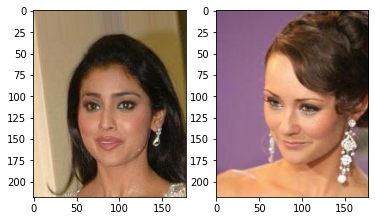

In [10]:
import matplotlib.image as mpimg
img_A = mpimg.imread(f"../dataset/prep_data/{targ_name_test[0]}.jpg")
img_B = mpimg.imread(f"../dataset/prep_data/{dis_name_test[0]}.jpg")

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A);
ax[1].imshow(img_B);

In [11]:
#InceptionV3 output layer information 
#https://cloud.google.com/tpu/docs/inception-v3-advanced
#8*8*2048 -> 1001
features_shape = 2048
attention_features_shape = 64 

#Hyperparameters
BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dims_speaker = 1024
embedding_dims_listener = 512
units = 512
vocab_size = 10
message_length = 10
num_steps = len(targ_name_train) // BATCH_SIZE

In [12]:
# EPS_END = 0.05
# EPS_START = 0.9
# EPS_DECAY = 200
# EPS_SKRMEISTER  = 0
# use_true = False
prep = Preparation()

In [13]:
training_data = tf.data.Dataset.from_tensor_slices((targ_name_train, dis_name_train))
training_data = training_data.map(lambda t, d: tf.numpy_function(prep.map_func, [t, d], [tf.float32, tf.float32]))
training_data = training_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [14]:
speaker = GRU_Decoder(embedding_dims_speaker, units, vocab_size)
listener = GRU_Encoder(embedding_dims_listener, units, vocab_size)
encoder_s = CNN_Encoder(embedding_dims_listener)
encoder_l = CNN_Encoder(embedding_dims_listener)

In [15]:
def matrix_sim(v, u_t, u_d, b):
    vals_ut = []
    vals_ud = []

    for i in range(b):
        #Dot product between embedded v and features of target
        dot_p_t = tf.tensordot(u_t[i], tf.transpose(v), axes=1)
        val_t = tf.norm(dot_p_t, ord='euclidean')
        vals_ut.append(val_t)

        #Dot product between embedded v and features of distractor
        dot_p_d = tf.tensordot(u_d[i], tf.transpose(v), axes=1)
        val_d = tf.norm(dot_p_d, ord='euclidean')
        vals_ud.append(val_d)
    
    return vals_ut, vals_ud 

In [27]:
optimizer_l = tf.keras.optimizers.Adam()
loss_object_l = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

def loss_function_l(real, pred):
  loss_ = loss_object_l(real, pred)
  return loss_

optimizer_s = tf.keras.optimizers.Adam()

def loss_function_s(pred,b_size,b_num):
    """
      Takes the predicted probabilities and extract a random 
    """
    # sample = random.random()
    # eps_threshold = EPS_END + (EPS_START - EPS_END) * \
    #   math.exp(-1* b_num / EPS_DECAY)
    print(pred)
    log_probs = tf.math.log(pred) 
    print(log_probs)
    # if sample > eps_threshold:
    samples = tf.cast(tf.random.categorical(log_probs, 1), tf.int32)
    # else:
    #   samples = tf.convert_to_tensor(np.random.randint(0,10,size=(b_size,1)),dtype=tf.int32)

    row_indices = tf.reshape(tf.range(b_size),(b_size,1))
    full_indices = tf.concat([row_indices,samples],axis=1)
    loss_ = tf.gather_nd(log_probs, full_indices)

    return loss_, samples

In [28]:
checkpoint_path = "./checkpointsa2a/train"
ckpt = tf.train.Checkpoint(speaker = speaker,
                           listener = listener,
                           encoder_s = encoder_s,
                           encoder_l = encoder_l,
                           optimizer_l = optimizer_l,
                           optimizer_s = optimizer_s)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
#Optional
# if ckpt_manager.latest_checkpoint:
#   start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
#   # restoring the latest checkpoint in checkpoint_path
#   ckpt.restore(ckpt_manager.latest_checkpoint)

In [29]:
loss_plot_s = []
loss_plot_l = []

In [30]:
def train_step(target_image, distractor_image, b_size, b_num):
    loss_s = 0
    loss_l = 0
    r_n = random.uniform(0,1)
    # if r_n <= 0.5:
    #     t=0
    # else:
    #     t=1
    t = 0

    hidden_s = speaker.reset_state(batch_size=b_size)
    hidden_l = listener.reset_state(batch_size=b_size)

    decoder_input = tf.expand_dims([1]*b_size,1,)
    m = decoder_input

    with tf.GradientTape() as tape_speaker:
        #Encode the image through CNN
        features_s_t = encoder_s(target_image)
        features_s_d = encoder_s(distractor_image)


        features_s_u = tf.concat([features_s_t, features_s_d],-1)

        for i in range(1,10):
            predictions, hidden, _ = speaker(decoder_input, features_s_u, hidden_s)

            pred_probs = tf.nn.softmax(predictions)
            log_probs = tf.math.log(pred_probs)

            with tape_speaker.stop_recording():
                col_indices = tf.cast(tf.random.categorical(log_probs, 1), tf.int32)
                row_indices = tf.reshape(tf.range(target.shape[0]),(target.shape[0],1))
                full_indices = tf.concat([row_indices,col_indices],axis=1)
            
            loss_ = tf.gather_nd(log_probs, full_indices)
          
            loss_s += loss_

            m = tf.concat([m, teacher],1)
            decoder_input = m[:,i]
            

        with tape_speaker.stop_recording():
            #Listener needs to be figured out look back at the papers we saw that were already doing this.
            #I think that there is a specific loss function that should not be too difficult to figure out
            #Maybe to do with normalization. Once we crack this part I am almost certain that the dominoes
            #Will fall ;) Good night.
            with tf.GradientTape() as tape_listener:

                u_t = encoder_l(target_image)
                u_d = encoder_l(distractor_image)

                #Compute loss for listener
                v, _ = listener(m, hidden_l)

                reward = []
                vals_ut, vals_ud = matrix_sim(v, u_t, u_d, b_size)

                with tape_listener.stop_recording():
                    mask = tf.math.greater(vals_ut, vals_ud)
                    rewards = tf.where(mask, 1, -1)

                #Construct the labels (did we recognize the target and the distractor)
                preds = []
                for i in range(b_size):
                    temp = [None, None]
                    temp[0] = vals_ut[i] / (vals_ut[i]+vals_ud[i])
                    temp[1] = vals_ud[i] / (vals_ut[i]+vals_ud[i])
                    preds.append(temp)

                preds = tf.convert_to_tensor(preds, dtype=tf.float32)
                # print(preds)
                real = tf.convert_to_tensor([[1,0]] * b_size, dtype=tf.float32)

                curr_loss = loss_function_l(preds, real)
                loss_l += curr_loss

        rewards = tf.reshape(tf.cast(rewards, tf.float32), (b_size,1))
        loss_s = tf.math.multiply(loss_s, rewards)
        loss_s = -tf.reduce_mean(loss_s)

    total_loss_s = loss_s
    trainable_vars_s = encoder_s.trainable_variables + speaker.trainable_variables
    # trainable_vars_s = speaker.trainable_variables
    #Gradient (speaker)
    gradients_s = tape_speaker.gradient(loss_s, trainable_vars_s)
    #Optimizer (speaker)
    optimizer_s.apply_gradients(zip(gradients_s, trainable_vars_s))

    #Trainable variables for encoder + decoder (listener)
    # trainable_vars_l = encoder_l.trainable_variables + listener.trainable_variables
    trainable_vars_l = listener.trainable_variables
    #Gradient (listener)
    gradients_l = tape_listener.gradient(loss_l, trainable_vars_l)
    #Optimizer (listener)
    optimizer_l.apply_gradients(zip(gradients_l, trainable_vars_l))

    return loss_s, total_loss_s, loss_l

In [31]:
val_data = tf.data.Dataset.from_tensor_slices((targ_name_val, dis_name_val))
val_data = val_data.map(lambda t, d: tf.numpy_function(prep.map_func, [t, d], [tf.float32, tf.float32]))
val_data = val_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [32]:
def evaluate(data):
    total_right = 0
    total_wrong = 0

    for (batch, (target_image, distractor_image)) in enumerate(data):
        hidden_s = speaker.reset_state(batch_size=target_image.shape[0])
        hidden_l = listener.reset_state(batch_size=target_image.shape[0])

        decoder_input = tf.expand_dims([1]*target_image.shape[0],1)
        m = decoder_input

        r_n = random.uniform(0,1)
        if r_n <= 0.5:
            t=0
        else:
            t=1

        #Encode the image through CNN
        features_s_t = encoder_s(target_image)
        features_s_d = encoder_s(distractor_image)
       
        # if not t:
        features_s_u = tf.concat([features_s_t, features_s_d],-1)
        # else:
            # features_s_u = tf.concat([features_s_d, features_s_t],-1)

        #make sure that these are 256+256 = 512 and not 32+32 = 64
        for i in range(1,10):
            predictions, hidden, _ = speaker(decoder_input, features_s_u, hidden_s)

            teacher = tf.math.argmax(predictions, axis=1)
            teacher = tf.reshape(tf.cast(teacher, tf.int32),(target_image.shape[0],1))
            
            decoder_input = teacher

            m = tf.concat([m, decoder_input],1)


        u_t = encoder_l(target_image)
        u_d = encoder_l(distractor_image)

        v, _ = listener(m, hidden_l)
        reward = []
        vals_ut, vals_ud = matrix_sim(v, u_t, u_d, target_image.shape[0])

        mask = tf.math.greater(vals_ut, vals_ud)
        total_right += np.sum(mask.numpy())
        total_wrong += np.sum(mask.numpy()==False)
    
    acc = total_right / (total_right+total_wrong)

    return acc, total_right, total_wrong

In [33]:
EPOCHS = 50
for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0
    total_loss_l = 0

    for (batch, (target_image, distractor_image)) in enumerate(training_data):
        batch_loss, t_loss, l_loss = train_step(target_image, distractor_image, target_image.shape[0],batch)
        total_loss += t_loss
        total_loss_l += l_loss

        if batch % 250 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy()))
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, l_loss))
            acc, tot_right, tot_wrong = evaluate(val_data)
            tot = tot_right + tot_wrong
            print(f'Epoch {epoch+1} Batch {batch} Accuracy of Validation Set {acc} for {tot} samples')

    # storing the epoch end loss value to plot later
    loss_plot_s.append(total_loss / num_steps)
    loss_plot_l.append(total_loss_l / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

      nan       nan       nan       nan 13.930175
        nan 14.095103 13.667822]
 [14.195331       nan       nan       nan       nan       nan 13.930175
        nan 14.095103 13.667822]
 [14.195331       nan       nan       nan       nan       nan 13.930175
        nan 14.095103 13.667822]
 [14.195331       nan       nan       nan       nan       nan 13.930175
        nan 14.095103 13.667822]
 [14.195331       nan       nan       nan       nan       nan 13.930175
        nan 14.095103 13.667822]
 [14.195331       nan       nan       nan       nan       nan 13.930175
        nan 14.095103 13.667822]
 [14.195331       nan       nan       nan       nan       nan 13.930175
        nan 14.095103 13.667822]
 [14.195331       nan       nan       nan       nan       nan 13.930175
        nan 14.095103 13.667822]
 [14.195331       nan       nan       nan       nan       nan 13.930175
        nan 14.095103 13.667822]
 [14.195331       nan       nan       nan       nan       nan 13.930175
     

ValueError: Shape mismatch: The shape of labels (received (64,)) should equal the shape of logits except for the last dimension (received (32, 2)).

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((targ_name_test, dis_name_test))
test_data = test_data.map(lambda t, d: tf.numpy_function(prep.map_func, [t, d], [tf.float32, tf.float32]))
test_data = test_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
plt.plot(loss_plot_s)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot Speaker')
plt.show()

In [ ]:
plt.plot(loss_plot_l)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot Listener')
plt.show()

In [ ]:
print(loss_plot_l)